In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from os.path import join, basename
from glob import glob

from global_config import RANDOM_SEED, IMAGE_SIZE, FOLDER_IMAGES, FOLDER_MRKS
from local_config import FOLDER_MODELS, FILE_DATASET

from skmultilearn.model_selection import iterative_train_test_split

from keras import backend as K
from keras.models import load_model
from custom_metrics import eye_localization_fvc, eye_localization_accuracy
from icao_dataset import ICAODataset
from utils import plot, load

%matplotlib inline

Using TensorFlow backend.


In [2]:
PATH_TO_ROOT = '../../'

FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DATASET = join(PATH_TO_ROOT, FILE_DATASET)
FILE_MODEL = join(FOLDER_MODELS, 'model_2022_07_13-21_29_34.h5')

print(FOLDER_MODELS)
print(FILE_DATASET)
print(FILE_MODEL)

../../models/unsupervised_supervised/
../../data/cropped_faces_eyes/dataset_dlib.pkl
../../models/unsupervised_supervised/model_2022_07_13-21_29_34.h5


In [3]:
sess = K.get_session()

# Data Loading 

In [4]:
dataset = pkl.load(open(FILE_DATASET, "rb"))

In [5]:
x = np.array(dataset.images)
mrks = np.array(dataset.mrks)
y_reqs = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])
y_eyes = np.array([mrk_file.right_eye.center().as_list() + mrk_file.left_eye.center().as_list() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y_reqs.shape, y_reqs.dtype)
print(y_eyes.shape, y_eyes.dtype)
print(len(mrks))

(4999, 160, 160, 3) float32
(4999, 23) int32
(4999, 4) float64
4999


In [6]:
x /= 255
y_eyes /= x.shape[1]

In [7]:
np.random.seed(RANDOM_SEED)
TEST_SIZE = 0.1

_, _, x_val_idx, y_val_reqs = iterative_train_test_split(
    np.arange(x.shape[0]).reshape(-1, 1),
    y_reqs,
    test_size=TEST_SIZE
)
x_val_idx = x_val_idx.ravel()
x_val = x[x_val_idx]
y_val_eyes = y_eyes[x_val_idx]

print(x_val.shape, y_val_reqs.shape, y_val_eyes.shape)

(509, 160, 160, 3) (509, 23) (509, 4)


In [8]:
model = load_model(FILE_MODEL)

list_files = [PATH_TO_ROOT + 'data/cropped_faces/images/afwDB_0.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred_clf, y_pred_reg = model.predict(im)

print("Reqs:")
for y_pred in y_pred_clf[0]:
    print(y_pred)

print("\nEyes:")
for y_pred in y_pred_reg[0]:
    print(y_pred)

Instructions for updating:
Colocations handled automatically by placer.
../../data/cropped_faces/images/afwDB_0.png


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



Reqs:
0.6480921
0.9347415
0.9957387
0.08281675
0.991169
0.9998725
0.97726715
0.27883765
0.96358013
0.053408027
0.20580027
0.14253017
0.9828384
0.471276
0.8292505
0.99030715
0.7546116
0.9796297
0.89305204
0.6584904
0.9751569
0.827954
0.9905076

Eyes:
0.42364126
0.449199
0.578478
0.44857737


In [9]:
_, y_pred_eyes = model.predict(x_val)

In [10]:
d_eye_1 = eye_localization_accuracy(y_val_eyes, y_pred_eyes, max_threshold=0.1)
d_eye_1_2 = eye_localization_accuracy(y_val_eyes, y_pred_eyes, min_threshold=0.1, max_threshold=0.2)
d_eye_2_3 = eye_localization_accuracy(y_val_eyes, y_pred_eyes, min_threshold=0.2, max_threshold=0.3)
d_eye_3 = eye_localization_accuracy(y_val_eyes, y_pred_eyes, min_threshold=0.3)

print(d_eye_1.eval(session=sess))
print(d_eye_1_2.eval(session=sess))
print(d_eye_2_3.eval(session=sess))
print(d_eye_3.eval(session=sess))

0.4263261296660118
0.48722986247544203
0.07072691552062868
0.0


#  Error Analysis

### Images with worst `d_eyes`

In [11]:
FOLDER_OUTPUT = "error_analysis"

In [12]:
d_eyes = eye_localization_fvc(y_val_eyes, y_pred_eyes).eval(session=sess)
print(d_eyes.min(), d_eyes.max())

0.01748566682929265 0.4645883515093726


In [13]:
d_eyes_argsort = np.argsort(d_eyes)

worst_indices = d_eyes_argsort[-30:]
filenames = np.array(dataset.image_files)[x_val_idx]

for index in worst_indices:
    im = (x_val[index] * 255).astype(np.uint8)
    y_true = y_val_eyes[index] * IMAGE_SIZE[0]
    y_pred = y_pred_eyes[index] * IMAGE_SIZE[0]
    d_eye = d_eyes[index]
    
    true_r = tuple(y_true[:2].astype(np.int))
    true_l = tuple(y_true[2:].astype(np.int))
    pred_r = tuple(y_pred[:2].astype(np.int))
    pred_l = tuple(y_pred[2:].astype(np.int))
    cv2.circle(im, true_r, radius=0, color=(0, 255, 0))
    cv2.circle(im, true_l, radius=0, color=(0, 255, 0))
    cv2.circle(im, pred_r, radius=0, color=(255, 255, 0))
    cv2.circle(im, pred_l, radius=0, color=(255, 255, 0))
    
    cv2.imwrite(join(FOLDER_OUTPUT, f"{np.round(d_eye, 3):.3f}.png"), im)

# Heatmap of Eye's predictions 

In [89]:
def heatmap(y_pred):
    y_pred = (y_pred * IMAGE_SIZE[0]).astype(np.uint)
    im = np.zeros(IMAGE_SIZE)
    
    for xl, yl, xr, yr in y_pred:
        im[yl, xl] += 1
        im[yr, xr] += 1
    return im

In [95]:
FILE_MODEL = FILE_MODEL = join(FOLDER_MODELS, 'model_2022_08_06-11_38_47.h5')

model = load_model(FILE_MODEL)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [96]:
_, y_pred_eyes = model.predict(x_val)
y_pred_eyes

array([[0.42533278, 0.45768124, 0.5762939 , 0.45392954],
       [0.42573524, 0.45227724, 0.5744512 , 0.44815603],
       [0.42006063, 0.45833614, 0.56966835, 0.45283583],
       ...,
       [0.42096362, 0.45062664, 0.5702216 , 0.4467097 ],
       [0.41828883, 0.4406848 , 0.5740653 , 0.43589523],
       [0.42004097, 0.44625118, 0.5771619 , 0.44308105]], dtype=float32)

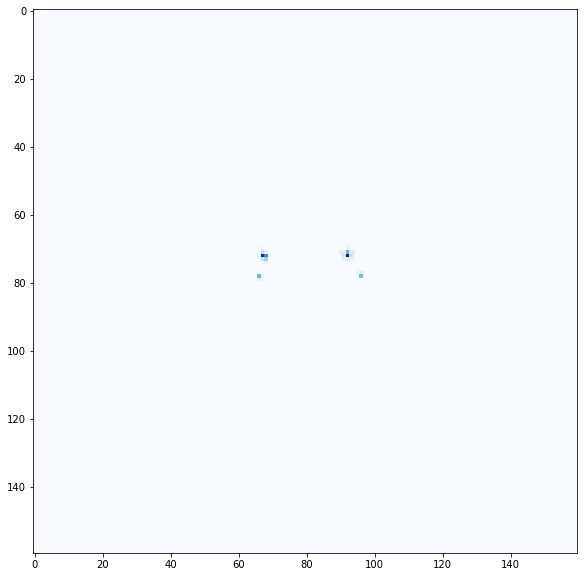

In [97]:
im_heatmap = heatmap(y_pred_eyes)

plt.figure(figsize=(10, 10))
plt.imshow(im_heatmap, cmap="Blues")

In [98]:
y_pred = (y_pred_eyes * IMAGE_SIZE[0]).astype(np.uint)
print(y_pred[:, :2].mean(axis=0))
print(y_pred[:, 2:].mean(axis=0))

[67.16502947 73.26522593]
[92.77013752 72.81335953]


In [99]:
import pandas as pd
from collections import Counter, defaultdict

count_left = defaultdict(int)
count_right = defaultdict(int)
for xl, yl, xr, yr in y_pred:
    count_left[(xl, yl)] += 1
    count_right[(xr, yr)] += 1
    
df_left = pd.DataFrame(Counter(count_left).most_common(n=10), columns=["pixel_left", "n_left"])
df_right = pd.DataFrame(Counter(count_right).most_common(n=10), columns=["pixel_right", "n_right"])
pd.concat([df_left, df_right], axis=1)

,pixel_left,n_left,pixel_right,n_right
0,"(67, 72)",138,"(92, 72)",144
1,"(68, 72)",92,"(92, 71)",71
2,"(66, 78)",69,"(96, 78)",64
3,"(68, 73)",50,"(93, 72)",34
4,"(67, 73)",35,"(91, 72)",28
5,"(67, 71)",32,"(93, 71)",19
6,"(66, 79)",15,"(96, 77)",18
7,"(68, 71)",12,"(92, 73)",17
8,"(68, 74)",12,"(91, 71)",16
9,"(66, 72)",10,"(90, 71)",14
